In [2]:
import numpy as np
import math
import itertools as it
import scipy as sp
import scipy.sparse as sps
import scipy.sparse.linalg as spslin
import scipy.optimize as opt

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
from matplotlib.animation import FuncAnimation
#Plot parameters
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.style.use(['dark_background'])

In [3]:
def ham(L, J, az, ay, B, PBC):
    numstates = 2*L
    
    H_0 = np.zeros((numstates, numstates), dtype=complex)
    H_Rz = np.zeros((numstates, numstates), dtype=complex)
    H_Ry = np.zeros((numstates, numstates), dtype=complex)
    H_Bz = np.zeros((numstates, numstates), dtype=complex)
    
    for j in range(L):
        for js in range(2):
            jj = 2*j + js 
            jp = ((j+1) + L)%L 
            jm = ((j-1) + L)%L 
            
            H_Bz[jj, jj] += int((-1)**js)
            if not(PBC==0 and jp<j) : 
                H_0[jj, 2*jp + js] += -1
                H_Rz[jj, 2*jp + js + int((-1)**js)] += -((-1)**js)  
                H_Ry[jj, 2*jp + js] += -1j*((-1)**js)
            if not(PBC==0 and jm>j) : 
                H_0[jj, 2*jm + js] += -1
                H_Rz[jj, 2*jm + js + int((-1)**js)] += -((-1)**js)
                H_Ry[jj, 2*jm + js] += 1j*((-1)**js)
                
    return -J*H_0 + az*H_Rz + ay*H_Ry + B*H_Bz

In [4]:
def ham_dis(L, J_vec, az, ay, B_vec, mu_vec, PBC):
    numstates = 2*L
    
    H_0 = np.zeros((numstates, numstates), dtype=complex)
    H_Rz = np.zeros((numstates, numstates), dtype=complex)
    H_Ry = np.zeros((numstates, numstates), dtype=complex)
    H_Bz = np.zeros((numstates, numstates), dtype=complex)
    H_mu = np.zeros((numstates, numstates), dtype=complex)
    
    for j in range(L):
        for js in range(2):
            jj = 2*j + js 
            jp = ((j+1) + L)%L 
            jm = ((j-1) + L)%L 
            
            H_Bz[jj, jj] += int((-1)**js) * B_vec[j]
            H_mu[jj, jj] += mu_vec[j]
            if not(PBC==0 and jp<j) : 
                H_0[jj, 2*jp + js] += J_vec[j]
                H_Rz[jj, 2*jp + js + int((-1)**js)] += -((-1)**js)  
                H_Ry[jj, 2*jp + js] += -1j*((-1)**js)
            if not(PBC==0 and jm>j) : 
                H_0[jj, 2*jm + js] += J_vec[j]
                H_Rz[jj, 2*jm + js + int((-1)**js)] += -((-1)**js)
                H_Ry[jj, 2*jm + js] += 1j*((-1)**js)
                
    return -H_0 + az*H_Rz + ay*H_Ry + H_Bz + H_mu

In [5]:
# cdagc operators for spinful fermions with spin exchange

# =============================================================================
# Parameters    
L = 4
N = L
s = 1/2
d = int(2*s+1)
numsites = L*d
numstates = math.comb(numsites, N)

# =============================================================================
# Basis states 
pos = np.array(list(it.combinations(range(numsites), N)))
size = np.shape(pos)
statemat = np.zeros((numstates,numsites), dtype=int)
for si in range(size[0]):
    for sj in range(size[1]):
        statemat[si,pos[si,sj]]=1
statemat0 = np.copy(statemat)        

# =============================================================================
cdagc = np.zeros((L, d, L, d), dtype = object)

for j in range(L):
    for jp in np.array([j, ((j+1) + L)%L]):
        for m in range(d):
            for mp in range(d):
                cdagc[jp, mp, j, m] = sps.lil_matrix((numstates,numstates), dtype=int)  
                jj = 2*j+m
                jjp = 2*jp+mp

                for i_state in range(numstates):
                    staterow = np.copy(statemat[i_state, :])

                    if (abs(jjp-jj) > 1) and (staterow[jjp]==0) and (staterow[jj]==1):
                        sump = sum(staterow[min(jjp,jj)+1:max(jjp,jj)])
                        newrow = np.copy(staterow)
                        newrow[jj] = 0
                        newrow[jjp] = 1                 
                        rowp = np.array(np.nonzero((statemat==newrow).all(axis=1))).flatten()
                        if np.size(rowp) != 0: 
                            i_statep = rowp[0]
                            cdagc[jp, mp, j, m][i_statep, i_state] = (-1)**(sump)

                    elif ((jjp==jj) and (staterow[jj]==1)) or ((abs(jjp-jj)==1) and (staterow[jjp]==0) and (staterow[jj]==1)): 
                        newrow = np.copy(staterow)
                        newrow[jj] = 0
                        newrow[jjp] = 1
                        rowp = np.array(np.nonzero((statemat==newrow).all(axis=1))).flatten()
                        if np.size(rowp) != 0:  
                            i_statep = rowp[0]
                            cdagc[jp, mp, j, m][i_statep, i_state]=1;        

                cdagc[jp, mp, j, m] = cdagc[jp, mp, j, m].tocsr()
#                 cdagc[j, m, jp, mp] = cdagc[jp, mp, j, m].H
#                 sps.save_npz("../Data/cdagc_wire/cdagc_wire_L=" + str(L) + "_N=" + str(N) + "_jp=" + str(jp) + "_"+str(mp) + "_"+str(j) + "_"+str(m) + ".npz", cdagc[jp, mp, j, m])

In [5]:
def ham_int(L, N, J, az, ay, B, U, V, PBC):
    s = 1/2
    d = int(2*s+1)
    numsites = L*d
    numstates = math.comb(numsites, N)
    
    cdagc = np.zeros((L, d, L, d), dtype = object)
    for j in range(L):
        for jp in np.array([j, ((j+1) + L)%L]):
            for m in range(d):
                for mp in range(d):
                    cdagc[jp, mp, j, m] = sps.load_npz("../Data/cdagc_wire/cdagc_wire_L=" + str(L) + "_N=" + str(N) + "_jp=" + str(jp) + "_"+str(mp) + "_"+str(j) + "_"+str(m) + ".npz")
#                     cdagc[j, m, jp, mp] = cdagc[jp, mp, j, m].H
    
    H_0 = sps.csr_matrix((numstates, numstates), dtype=complex)
    H_Rz = sps.csr_matrix((numstates, numstates), dtype=complex)
    H_Ry = sps.csr_matrix((numstates, numstates), dtype=complex)
    H_B = sps.csr_matrix((numstates, numstates), dtype=complex)
    H_U = sps.csr_matrix((numstates, numstates), dtype=complex)
    H_V = sps.csr_matrix((numstates, numstates), dtype=complex)
    H = sps.csr_matrix((numstates, numstates), dtype=complex)
    
    for j in range(L-1):
        for m in range(d):
            H_0 += cdagc[j+1, m, j, m] 
            for mp in range(d):
                H_Rz += -1j * sy[mp, m] * cdagc[j+1, mp, j, m] 
                H_Ry += 1j * sz[mp, m] * cdagc[j+1, mp, j, m]
                H_B += (1/2) * sz[mp, m] * cdagc[j, mp, j, m]
                H_V += (1/2) * cdagc[j, m, j, m] * cdagc[j+1, mp, j+1, mp]
                if m != mp: H_U += (1/2) * cdagc[j, m, j, m] * cdagc[j, mp, j, mp]
    for m in range(d):
        for mp in range(d): 
            H_B += sz[mp, m] * cdagc[L-1, mp, L-1, m]
    H_U += cdagc[L-1, 0, L-1, 0] * cdagc[L-1, 1, L-1, 1]
    
    H = -J*H_0 + az*H_Rz + ay*H_Ry + B*H_B + U*H_U + V*H_V
                
    return (H + H.H)

In [6]:
def I(L, N, PBC):
    s = 1/2
    d = int(2*s+1)
    numsites = L*d
    numstates = math.comb(numsites, N)
    
    cdagc = np.zeros((L, d, L, d), dtype = object)
    for j in range(L):
        for jp in np.array([j, ((j+1) + L)%L]):
            for m in range(d):
                for mp in range(d):
                    cdagc[jp, mp, j, m] = sps.load_npz("../Data/cdagc_wire/cdagc_wire_L=" + str(L) + "_N=" + str(N) + "_jp=" + str(jp) + "_"+str(mp) + "_"+str(j) + "_"+str(m) + ".npz")
#                     cdagc[j, m, jp, mp] = cdagc[jp, mp, j, m].H
    
    I_op = sps.csr_matrix((numstates, numstates), dtype=complex)
    I_tot = sps.csr_matrix((numstates, numstates), dtype=complex)
    
    for j in range(L-1):
        for m in range(d):
            I_tot += 1j*cdagc[j+1, m, j, m]
            if j==L//2: I_op += 1j*cdagc[j+1, m, j, m]
                
#     return (I_op + I_op.H)
    return (I_tot + I_tot.H)

In [7]:
# 1D SOC

L_list = 100+10*np.arange(11)
dp = 1e-6
par_list = 0.1*np.arange(1, 2)
J = 1
B_list = 0.05*np.arange(1, 2)
PBC = 0
i_state = 0

QFI_table = np.zeros((len(L_list)*len(par_list), 5), dtype=float)

for i_L, L in enumerate(L_list):
    numstates = 2*L
    N_state = 1 # N_state = L, for half-filled many-body case
    E_table = np.zeros((numstates, len(B_list)))
        
    I_tot = np.zeros((numstates, numstates), dtype=complex)
    for j in range(L):
        for js in range(2):
            jj = 2*j + js 
            jp = ((j+1) + L)%L 
            jm = ((j-1) + L)%L
            if not(PBC==0 and jp<j) : I_tot[jj, 2*jp + js] += 1j
            if not(PBC==0 and jm>j) : I_tot[jj, 2*jm + js] += -1j
    E_I, V_I = np.linalg.eigh(I_tot)
    pi = np.zeros((numstates), dtype=object)
    for ii in range(numstates) : pi[ii] = np.outer(V_I[:,ii], V_I[:,ii].conj())
        
    for i_B, B in enumerate(B_list):            
        for i_par, par in enumerate(par_list):
            az = par; ay = az
            H0 = ham(L, J, az, ay, B, PBC) 
            val0, vec0 = np.linalg.eigh(H0)
            psi0 = vec0[:, i_state] 
            E_table[:, i_B] = val0

            az = par+dp; ay = az
            H1 = ham(L, J, az, ay, B, PBC) 
            val1, vec1 = np.linalg.eigh(H1)
            for ii in range(numstates):
                if np.linalg.norm(vec1[:, ii] - vec0[:, ii]) > np.linalg.norm(vec1[:, ii] + vec0[:, ii]): vec1[:, ii] = -vec1[:, ii]
            psi1 = vec1[:, i_state]

            overlap = 0
            for i_state1 in range(N_state):
                for i_state2 in range(N_state):
                    overlap += (np.abs(np.inner(vec1[:, i_state1].conj(), vec0[:, i_state2])))**2

            CFI = 0
            for ii in range(numstates):
                if abs(psi0.T.conj()@(pi[ii])@psi0) > 1e-15 : CFI +=  ((psi1.T.conj()@pi[ii]@psi1 - psi0.T.conj()@pi[ii]@psi0)**2) / (psi0.T.conj()@pi[ii]@psi0)
            QFI_table[i_L*len(par_list)+i_par, :] = np.array([L, par, 4*(N_state - overlap)/(dp**2), CFI.real/(dp**2), val0[N_state]-val0[N_state-1]])


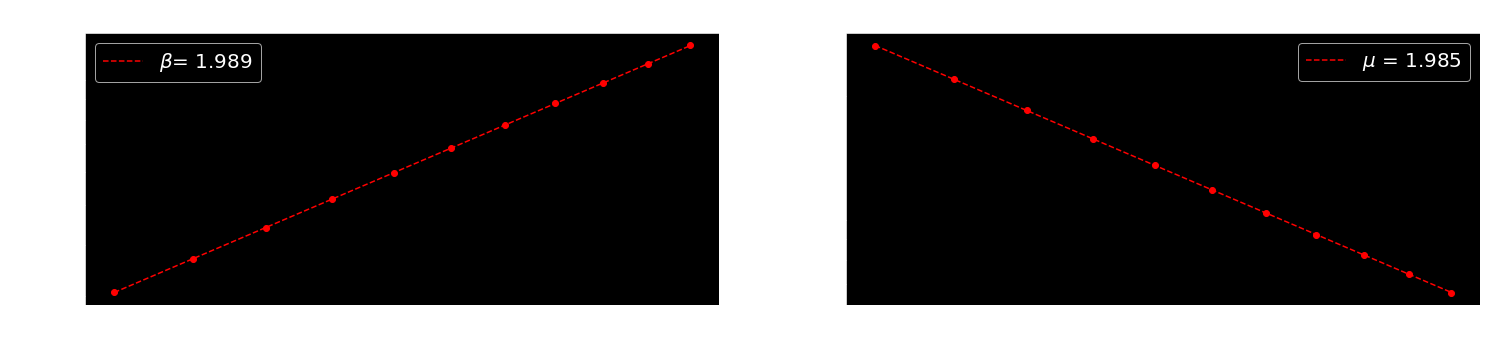

In [8]:
def test_func(x, b, c): 
    return x*b + c

x = QFI_table[:, 0]
y1 = QFI_table[:, 2]
y2 = QFI_table[:, 4]

b = 2; c = 1
popt1, pcov1 = opt.curve_fit(test_func, np.log(x), np.log(y1), p0=[b,c], maxfev=20000)
popt2, pcov2 = opt.curve_fit(test_func, np.log(x), np.log(y2), p0=[b,c], maxfev=20000)
b1 = popt1[0]; c1 = popt1[1]
b2 = popt2[0]; c2 = popt2[1]

fig = plt.figure(figsize=(25,5))

ax = fig.add_subplot(1, 2, 1)
ax.plot(x, y1, "or")
ax.plot(x, (x**b1)*np.exp(c1), "--r", label=r"$\beta$= %.3f" %(b1))
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc="best")
ax.set_xlabel(r"$L$")
ax.set_title(r"QFI $\sim L^{\beta}$", fontsize=20)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x, y2, "or")
ax.plot(x, (x**b2)*np.exp(c2), "--r", label=r"$\mu$ = %.3f" %(-b2))
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc="best")
ax.set_xlabel(r"$L$")
ax.set_title(r"Energy Gap $\sim L^{-\mu}$", fontsize=20)

plt.show()

In [9]:
# 1D SOC + disorder

L_list = np.array([50, 100, 150, 200, 250])
J = 1
dp = 1e-6
PBC = 0
i_state = 0
N_dis = 100

for case in range(1):
    print(case)
    if case==0: B = 0.05; par = 0.1
    if case==1: B = 0.9; par = 0.1
    if case==2: B = 0.9; par = 0.9
    if case==3: B = 0.05; par = 0.9

    L_table = np.zeros((len(L_list), 4), dtype=float)
    L_table[:, 0] = L_list
    for i_L, L in enumerate(L_list):
        numstates = 2*L
        N_state = 1 # N_state = L, for half-filled many-body case     
        n_hole = L//50
        
        for dis in range(3):
            if dis==0: Wj = J/100; Wb = 0/10; Wm = 0
            if dis==1: Wj = 0/100; Wb = B/10; Wm = 0
            if dis==2: Wj = 0/100; Wb = 0/10; Wm = 10

            QFI_table = np.zeros((N_dis, 2), dtype=float)
            for i_dis in range(N_dis):          
                np.random.seed()
                Wj_list = Wj*(np.random.random(L))
                Wb_list = 2*Wb*(np.random.random(L)-0.5)
                site_list = np.random.permutation(L)[:n_hole]

                J_vec = J + Wj_list
                B_vec = B + Wb_list
                mu_vec = np.zeros((L))
                mu_vec[site_list] = Wm            

                az = par; ay = az
                H0 = ham_dis(L, J_vec, az, ay, B_vec, mu_vec, PBC)
                val0, vec0 = np.linalg.eigh(H0)
                psi0 = vec0[:, i_state] 

                az = par+dp; ay = az
                H1 = ham_dis(L, J_vec, az, ay, B_vec, mu_vec, PBC)
                val1, vec1 = np.linalg.eigh(H1)
                for ii in range(numstates):
                    if np.linalg.norm(vec1[:, ii] - vec0[:, ii]) > np.linalg.norm(vec1[:, ii] + vec0[:, ii]): vec1[:, ii] = -vec1[:, ii]
                psi1 = vec1[:, i_state]

                overlap = 0
                for i_state1 in range(N_state):
                    for i_state2 in range(N_state):
                        overlap += (np.abs(np.inner(vec1[:, i_state1].conj(), vec0[:, i_state2])))**2
                QFI_table[i_dis, :] = np.array([L, 4*(N_state - overlap)/(dp**2)])

            L_table[i_L, dis+1] = sum(QFI_table[:, 1])/N_dis

0


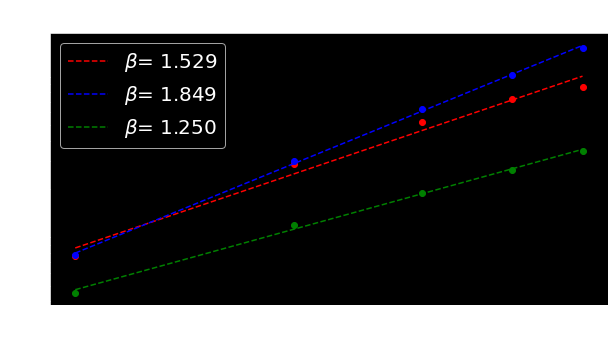

In [10]:
def test_func(x, b, c): 
    return x*b + c

x = L_table[:, 0]
y1 = L_table[:, 1]
y2 = L_table[:, 2]
y3 = L_table[:, 3]

b = 2; c = 1
popt1, pcov1 = opt.curve_fit(test_func, np.log(x), np.log(y1), p0=[b,c], maxfev=20000)
popt2, pcov2 = opt.curve_fit(test_func, np.log(x), np.log(y2), p0=[b,c], maxfev=20000)
popt3, pcov3 = opt.curve_fit(test_func, np.log(x), np.log(y3), p0=[b,c], maxfev=20000)
b1 = popt1[0]; c1 = popt1[1]
b2 = popt2[0]; c2 = popt2[1]
b3 = popt3[0]; c3 = popt3[1]

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(x, y1, "or")
ax.plot(x, (x**b1)*np.exp(c1), "--r", label=r"$\beta$= %.3f" %(b1))
ax.plot(x, y2, "ob")
ax.plot(x, (x**b2)*np.exp(c2), "--b", label=r"$\beta$= %.3f" %(b2))
ax.plot(x, y3, "og")
ax.plot(x, (x**b3)*np.exp(c3), "--g", label=r"$\beta$= %.3f" %(b3))
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc="best")
ax.set_xlabel(r"$L$")
ax.set_title(r"QFI $\sim L^{\beta}$", fontsize=20)

plt.show()

[0.05       0.1        0.09942314 0.00056335 0.00057149]


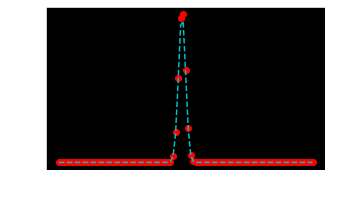

In [11]:
# Bayesian (single particle probe)

def Gauss(x, a, mean, sigma):
    return a * np.exp(-(x - mean)**2 / (2 * sigma**2))

L = 100
numstates = 2*L
N_state = 1
dp = 1e-6
par0_list = 0.1*np.arange(1, 2)
B_list = 0.05*np.arange(1, 2)
J = 1
PBC = 0
i_state = 0
n_iter = 2
n_exp = 500
M = n_iter * n_exp

I_tot = np.zeros((numstates, numstates), dtype=complex)
for j in range(L):
    for js in range(2):
        jj = 2*j + js 
        jp = ((j+1) + L)%L 
        jm = ((j-1) + L)%L
        if not(PBC==0 and jp<j) : I_tot[jj, 2*jp + js] += 1j
        if not(PBC==0 and jm>j) : I_tot[jj, 2*jm + js] += -1j
E_I, V_I = np.linalg.eigh(I_tot)
pi = np.zeros((numstates), dtype=object)
for ii in range(numstates) : pi[ii] = np.outer(V_I[:,ii], V_I[:,ii].conj())

sigma_table = np.zeros((len(B_list)*len(par0_list), 5))
for i_B, B in enumerate(B_list):            
    for i_par0, par0 in enumerate(par0_list):
        par_list = np.linspace(par0-0.02, par0+0.02, 101)
        
        az = par0; ay = az
        H0 = ham(L, J, az, ay, B, PBC)
        val0, vec0 = np.linalg.eigh(H0)
        psi0 = vec0[:, i_state] 
        
        az = par0+dp; ay = az
        H1 = ham(L, J, az, ay, B, PBC)
        val1, vec1 = np.linalg.eigh(H1)
        for ii in range(numstates):
            if np.linalg.norm(vec1[:, ii] - vec0[:, ii]) > np.linalg.norm(vec1[:, ii] + vec0[:, ii]): vec1[:, ii] = -vec1[:, ii]
        psi1 = vec1[:, i_state]
        
        overlap = 0
        for i_state1 in range(N_state):
            for i_state2 in range(N_state):
                overlap += (np.abs(np.inner(vec1[:, i_state1].conj(), vec0[:, i_state2])))**2
        Fq = 4*(N_state - overlap)/(dp**2)        
        
        p_list = np.zeros((numstates), dtype=float)
        for ii in range(numstates): p_list[ii] = abs(psi0.T.conj()@(pi[ii])@psi0)
        p_list /= np.sum(p_list) 
        
        site_list = np.zeros((numstates), dtype=int)
        np.random.seed()
        random_list = np.random.random(n_exp)
        for jj in range(1, numstates) :
            p_list[jj] += p_list[jj-1]
        for i_exp in range(n_exp):
            i_site = np.flatnonzero(p_list >= random_list[i_exp])[0]
            site_list[i_site] += 1
        
        lhood_list = np.zeros((len(par_list)), dtype=float)
        prior_list = np.ones((len(par_list)))
        post_list = np.zeros((len(par_list)), dtype=float)
        prob_list = np.zeros((numstates), dtype=float)
        post_table = np.zeros((len(par_list), 3), dtype=float)
        for i_iter in range(n_iter):

            for i_par, par in enumerate(par_list):
                az = par; ay = az
                H = ham(L, J, az, ay, B, PBC)
                psi = np.linalg.eigh(H)[1][:, 0]
                for ii in range(numstates): prob_list[ii] = abs(psi.T.conj()@(pi[ii])@psi)
                prob_list /= np.sum(prob_list)

                multi_coeff = 1 
                for jj in range(numstates):
                    if prob_list[jj] > 1e-14: multi_coeff *= sp.special.comb(n_exp-sum(site_list[:jj]), site_list[jj]) * (prob_list[jj])**(site_list[jj]) 
                lhood_list[i_par] = multi_coeff

            post_list = lhood_list * prior_list
            post_list /= np.sum(post_list)
            prior_list = post_list
        
        x = par_list; y = post_list
        mean = sum(x * y) / sum(y); sigma = np.sqrt(sum(y * (x - mean)**2) / sum(y))
        popt,pcov = opt.curve_fit(Gauss, x, y, p0=[max(y), mean, sigma], maxfev=20000)
        est = popt[1]
        err = popt[2]            
        sigma_table[i_B*len(par0_list)+i_par0, :] = np.array([B, par0, est, err, 1/np.sqrt(M*Fq)])
        print(sigma_table[i_B*len(par0_list)+i_par0, :])
        
        fig, ax = plt.subplots(figsize=(5, 3))
        ax.plot(x, y, "or")
        ax.plot(x, (max(y)) * np.exp(-(x - popt[1])**2 / (2 * (popt[2])**2)), "--c")
        plt.show()

In [12]:
# 1D SOC + interaction

L_list = np.arange(4, 7)
s = 1/2
d = int(2*s+1)
dp = 1e-6
par_list = 0.1*np.arange(1, 2)
J = 1
B = 0.01
U_list = 10*np.arange(1, 2)
PBC = 0
i_state = 0

sx = np.array([[0, 1], [1, 0]])
sy = np.array([[0, -1j], [1j, 0]])
sz = np.array([[1, 0], [0, -1]])

QFI_table = np.zeros((len(U_list)*len(L_list)*len(par_list), 6), dtype=float)

i_row = 0
for i_L, L in enumerate(L_list):
    print(L)
    numsites = L*d
    N = L
    numstates = round(sp.special.comb(numsites, N))
    N_state = 1
    E_table = np.zeros((numstates*len(U_list), 2))

    I_tot = I(L, N, PBC) 
    Neig = numstates//2
    D1, V1 = spslin.eigsh(I_tot, Neig, which='SA')
    D2, V2 = spslin.eigsh(I_tot, numstates - Neig, which='LA')
    E_I = np.concatenate((np.sort(D1), np.sort(D2)))
    V_I = np.concatenate((V1[:,np.argsort(D1)], V2[:,np.argsort(D2)]), axis=1)
    pi = np.zeros((numstates), dtype=object)        
    for ii in range(numstates) : pi[ii] = np.outer(V_I[:,ii], V_I[:,ii].conj())  
        
    for i_U, U in enumerate(U_list): 
        for i_par, par in enumerate(par_list):
            az = par; ay = az
            H0 = ham_int(L, N, J, az, ay, B, U, 0, PBC)
            val0, vec0 = spslin.eigsh(H0, 2, which='SA')
            vec0 = vec0[:, np.argsort(val0)]
            val0 = np.sort(val0)
            psi0 = vec0[:, i_state] 

            az = par+dp; ay = az
            H1 = ham_int(L, N, J, az, ay, B, U, 0, PBC)
            val1, vec1 = spslin.eigsh(H1, 2, which='SA')
            vec1 = vec1[:, np.argsort(val1)]
            val1 = np.sort(val1)
            psi1 = vec1[:, i_state]
            
            overlap = 0
            for i_state1 in range(N_state):
                for i_state2 in range(N_state):
                    overlap += (np.abs(np.inner(vec1[:, i_state1].conj(), vec0[:, i_state2])))**2

            CFI = 0
            for ii in range(numstates):
                if abs(psi0.T.conj()@(pi[ii])@psi0) > 1e-15 : CFI +=  ((psi1.T.conj()@pi[ii]@psi1 - psi0.T.conj()@pi[ii]@psi0)**2) / (psi0.T.conj()@pi[ii]@psi0) 

            QFI_table[i_row, :] = np.array([L, par, U, 4*(N_state - overlap)/(dp**2), CFI.real/(dp**2), val0[N_state]-val0[N_state-1]])
            i_row += 1            
   

4
5
6


[0.05       0.1        0.10192567 0.0048763  0.00425655]


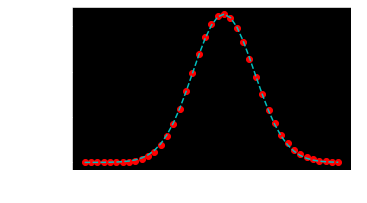

In [14]:
# Bayesian (many-body probe)

def Gauss(x, a, mean, sigma):
    return a * np.exp(-(x - mean)**2 / (2 * sigma**2))

L = 6
d = 2
numsites = L*d
N = L
numstates = round(sp.special.comb(numsites, N))
N_state = 1
dp = 1e-6
par0_list = 0.1*np.arange(1, 2)
B_list = 0.05*np.arange(1, 2)
U = 5
J = 1
theta = 0*np.pi/2
phi = 0*np.pi/2
PBC = 0
i_state = 0
n_iter = 2
n_exp = 500
M = n_iter * n_exp

sx = np.array([[0, 1], [1, 0]])
sy = np.array([[0, -1j], [1j, 0]])
sz = np.array([[1, 0], [0, -1]])

I_tot = I(L, N, PBC) 
Neig = numstates//2
D1, V1 = spslin.eigsh(I_tot, Neig, which='SA')
D2, V2 = spslin.eigsh(I_tot, numstates - Neig, which='LA')
E_I = np.concatenate((np.sort(D1), np.sort(D2)))
V_I = np.concatenate((V1[:,np.argsort(D1)], V2[:,np.argsort(D2)]), axis=1)
pi = np.zeros((numstates), dtype=object)        
for ii in range(numstates) : pi[ii] = np.outer(V_I[:,ii], V_I[:,ii].conj()) 

sigma_table = np.zeros((len(B_list)*len(par0_list), 5))
for i_B, B in enumerate(B_list):            
    for i_par0, par0 in enumerate(par0_list):
        par_list = np.linspace(par0-0.02, par0+0.02, 41)
        
        az = par0; ay = az
        H0 = ham_int(L, N, J, az, ay, B, U, 0, PBC)
        val0, vec0 = spslin.eigsh(H0, 2, which='SA')
        vec0 = vec0[:, np.argsort(val0)]
        val0 = np.sort(val0)
        psi0 = vec0[:, i_state]
        
        az = par0+dp; ay = az
        H1 = ham_int(L, N, J, az, ay, B, U, 0, PBC)
        val1, vec1 = spslin.eigsh(H1, 2, which='SA') 
        vec1 = vec1[:, np.argsort(val1)]
        val1 = np.sort(val1)
        psi1 = vec1[:, i_state]

        overlap = 0
        for i_state1 in range(N_state):
            for i_state2 in range(N_state):
                overlap += (np.abs(np.inner(vec1[:, i_state1].conj(), vec0[:, i_state2])))**2
        Fq = 4*(N_state - overlap)/(dp**2)
        
        p_list = np.zeros((numstates), dtype=float)
        for ii in range(numstates): p_list[ii] = abs(psi0.T.conj()@(pi[ii])@psi0)
        p_list /= np.sum(p_list) 
        
        site_list = np.zeros((numstates), dtype=int)
        np.random.seed()
        random_list = np.random.random(n_exp)
        for jj in range(1, numstates) :
            p_list[jj] += p_list[jj-1]
        for i_exp in range(n_exp):
            i_site = np.flatnonzero(p_list >= random_list[i_exp])[0]
            site_list[i_site] += 1
        
        lhood_list = np.zeros((len(par_list)), dtype=float)
        prior_list = np.ones((len(par_list)))
        post_list = np.zeros((len(par_list)), dtype=float)
        prob_list = np.zeros((numstates), dtype=float)
        post_table = np.zeros((len(par_list), 3), dtype=float)
        for i_iter in range(n_iter):
            for i_par, par in enumerate(par_list):                
                az = par; ay = az
                H = ham_int(L, N, J, az, ay, B, U, 0, PBC)
                val, vec = spslin.eigsh(H, 2, which='SA')
                vec = vec[:, np.argsort(val)]
                val = np.sort(val)
                psi = vec[:, i_state]
                for ii in range(numstates): prob_list[ii] = abs(psi.T.conj()@(pi[ii])@psi)
                prob_list /= np.sum(prob_list)

                multi_coeff = 1 
                for jj in range(numstates):
                    if prob_list[jj] > 1e-14: multi_coeff *= sp.special.comb(n_exp-sum(site_list[:jj]), site_list[jj]) * (prob_list[jj])**(site_list[jj]) 
                lhood_list[i_par] = multi_coeff

            post_list = lhood_list * prior_list
            post_list /= np.sum(post_list)
            prior_list = post_list
        
        x = par_list; y = post_list
        mean = sum(x * y) / sum(y); sigma = np.sqrt(sum(y * (x - mean)**2) / sum(y))
        popt,pcov = opt.curve_fit(Gauss, x, y, p0=[max(y), mean, sigma], maxfev=20000)
        est = popt[1]
        err = popt[2]            
        sigma_table[i_B*len(par0_list)+i_par0, :] = np.array([B, par0, est, err, 1/np.sqrt(M*Fq)])
        print(sigma_table[i_B*len(par0_list)+i_par0, :])
        
        fig, ax = plt.subplots(figsize=(5, 3))
        ax.plot(x, y, "or")
        ax.plot(x, (max(y)) * np.exp(-(x - popt[1])**2 / (2 * (popt[2])**2)), "--c")
        plt.show()

In [15]:
# 1D SOC + temp

L_list = 100*np.arange(1, 2)
dp = 1e-6
par_list = 0.02*np.arange(1, 51)
temp_list = np.array([0.01]) 
J = 1
B = 0.01 
PBC = 0

QFI_table = np.zeros((len(L_list)*len(par_list), 5), dtype=float)

for i_L, L in enumerate(L_list):
    numstates = 2*L
    I_tot = np.zeros((numstates, numstates), dtype=complex)
    for j in range(L):
        for js in range(2):
            jj = 2*j + js 
            jp = ((j+1) + L)%L 
            jm = ((j-1) + L)%L
            if not(PBC==0 and jp<j) : I_tot[jj, 2*jp + js] += 1j
            if not(PBC==0 and jm>j) : I_tot[jj, 2*jm + js] += -1j
    E_I, V_I = np.linalg.eigh(I_tot)
    pi = np.zeros((numstates), dtype=object)
    for ii in range(numstates) : pi[ii] = np.outer(V_I[:,ii], V_I[:,ii].conj())
        
    i_row = 0     
    for i_temp, temp in enumerate(temp_list):
        for i_par, par in enumerate(par_list):
            az = par; ay = az
            H0 = ham(L, J, az, ay, B, PBC)
            val0, vec0 = np.linalg.eigh(H0)
            Er0 = np.zeros((numstates))
            for ii in range(numstates):
                if np.exp(-val0[ii]/temp) > 1e-15:
                    pf = 0
                    for jj in range(numstates):
                        prob = np.exp(-(val0[jj]-val0[ii])/temp)
                        if prob > 1e-15: pf += prob
                    Er0[ii] = 1/pf
            Vr0 = vec0
            rho0 = np.zeros((numstates, numstates), dtype=complex)
            for ii in range(numstates): rho0 += Er0[ii]*np.outer(Vr0[:,ii], Vr0[:,ii].conj())

            az = par+dp; ay = az
            H1 = ham(L, J, az, ay, B, PBC)
            val1, vec1 = np.linalg.eigh(H1)
            for ii in range(numstates):
                if np.linalg.norm(vec1[:, ii] - vec0[:, ii]) > np.linalg.norm(vec1[:, ii] + vec0[:, ii]): vec1[:, ii] = -vec1[:, ii]
            Er1 = np.zeros((numstates))            
            for ii in range(numstates):
                if np.exp(-val1[ii]/temp) > 1e-15:
                    pf = 0
                    for jj in range(numstates):
                        prob = np.exp(-(val1[jj]-val1[ii])/temp)
                        if prob > 1e-15: pf += prob
                    Er1[ii] = 1/pf
            Vr1 = vec1
            rho1 = np.zeros((numstates, numstates), dtype=complex)
            for ii in range(numstates): rho1 += Er1[ii]*np.outer(Vr1[:,ii], Vr1[:,ii].conj())

            rho_qfi = 0
            for ii in range(numstates):
                if Er0[ii] > 1e-15: 
                    rho_qfi += ((abs(Er0[ii]-Er1[ii]))**2) / Er0[ii] + 4*Er0[ii] * (1 - (np.abs(np.inner((Vr0[:, ii]).conj(), Vr1[:, ii])))**2)
                    for jj in range(numstates):
                        if jj != ii and Er0[jj] > 1e-15:
                            rho_qfi += -(8*Er0[ii]*Er0[jj]/(Er0[ii]+Er0[jj])) * ((np.abs(np.inner((Vr0[:, ii]).conj(), Vr1[:, jj])))**2)
                            
            CFI = 0
            for ii in range(numstates): 
                if abs(np.trace(rho0@pi[ii])) > 1e-15 : CFI +=  ((np.trace(rho1@pi[ii]) - np.trace(rho0@pi[ii]))**2) / (np.trace(rho0@pi[ii]))

            QFI_table[i_row, :] = np.array([L, par, temp, rho_qfi/(dp**2), CFI.real/(dp**2)])
            i_row += 1

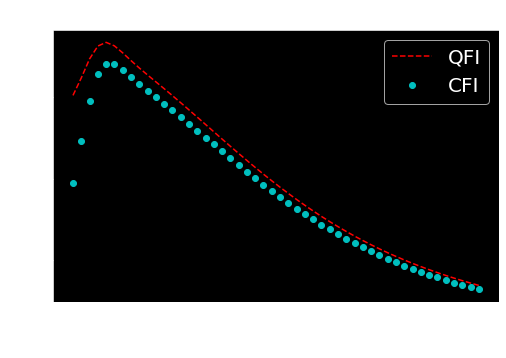

In [16]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(QFI_table[:, 1], QFI_table[:, 3], "--r", label=r"QFI")
ax.plot(QFI_table[:, 1], QFI_table[:, 4], "oc", label=r"CFI")
ax.set_xlabel(r"$\alpha_z$")
ax.legend(loc="best")
ax.set_title(r"$k_BT=0.01$", fontsize=20)

plt.show()

In [17]:
# 1D SOC + interaction + temp

L_list = 6*np.arange(1, 2)
s = 1/2
d = int(2*s+1)
dp = 1e-6
par_list = 0.1*np.arange(1, 2)
J = 1
B = 0.01
U_list = 0.05*np.arange(1, 2)
temp_list = 0.01*np.arange(1, 2)
PBC = 0
i_state = 0

sx = np.array([[0, 1], [1, 0]])
sy = np.array([[0, -1j], [1j, 0]])
sz = np.array([[1, 0], [0, -1]])

QFI_table = np.zeros((len(U_list)*len(temp_list), 6), dtype=float)

for i_L, L in enumerate(L_list):
    print(L)
    numsites = L*d
    N = L
    numstates = math.comb(numsites, N)
    N_state = 1
    I_tot = I(L, N, PBC) 
    Neig = numstates//2
    D1, V1 = spslin.eigsh(I_tot, Neig, which='SA')
    D2, V2 = spslin.eigsh(I_tot, numstates - Neig, which='LA')
    E_I = np.concatenate((np.sort(D1), np.sort(D2)))
    V_I = np.concatenate((V1[:,np.argsort(D1)], V2[:,np.argsort(D2)]), axis=1)
    pi = np.zeros((numstates), dtype=object)        
    for ii in range(numstates) : pi[ii] = np.outer(V_I[:,ii], V_I[:,ii].conj())
    
    for i_U, U in enumerate(U_list):
        for i_temp, temp in enumerate(temp_list):
            for i_par, par in enumerate(par_list):
            
                    az = par; ay = az
                    H0 = ham_int(L, N, J, az, ay, B, U, 0, PBC)
                    Neig = numstates//2 
                    D1, V1 = spslin.eigsh(H0, Neig, which='SA')
                    D2, V2 = spslin.eigsh(H0, numstates - Neig, which='LA')
                    val0 = np.concatenate((np.sort(D1), np.sort(D2)))
                    vec0 = np.concatenate((V1[:,np.argsort(D1)], V2[:,np.argsort(D2)]), axis=1)
                    Er0 = np.zeros((numstates))
                    for ii in range(numstates):
                        if np.exp(-val0[ii]/temp) > 1e-15:
                            pf = 0
                            for jj in range(numstates):
                                prob = np.exp(-(val0[jj]-val0[ii])/temp)
                                if prob > 1e-15: pf += prob
                            Er0[ii] = 1/pf
                    Vr0 = vec0
                    rho0 = np.zeros((numstates, numstates), dtype=complex)
                    for ii in range(numstates): rho0 += Er0[ii] * np.outer(Vr0[:,ii], Vr0[:,ii].conj())

                    az = par+dp; ay = az
                    H1 = ham_int(L, N, J, az, ay, B, U, 0, PBC)
                    Neig = numstates//2
                    D1, V1 = spslin.eigsh(H1, Neig, which='SA')
                    D2, V2 = spslin.eigsh(H1, numstates - Neig, which='LA')
                    val1 = np.concatenate((np.sort(D1), np.sort(D2)))
                    vec1 = np.concatenate((V1[:,np.argsort(D1)], V2[:,np.argsort(D2)]), axis=1)
                    for ii in range(numstates):
                        if np.linalg.norm(vec1[:, ii] - vec0[:, ii]) > np.linalg.norm(vec1[:, ii] + vec0[:, ii]): vec1[:, ii] = -vec1[:, ii]
                    Er1 = np.zeros((numstates))            
                    for ii in range(numstates):
                        if np.exp(-val1[ii]/temp) > 1e-15:
                            pf = 0
                            for jj in range(numstates):
                                prob = np.exp(-(val1[jj]-val1[ii])/temp)
                                if prob > 1e-15: pf += prob
                            Er1[ii] = 1/pf
                    Vr1 = vec1
                    rho1 = np.zeros((numstates, numstates), dtype=complex)
                    for ii in range(numstates): rho1 += Er1[ii] * np.outer(Vr1[:,ii], Vr1[:,ii].conj())

                    rho_qfi = 0
                    for ii in range(numstates):
                        if Er0[ii] > 1e-15: 
                            rho_qfi += ((abs(Er0[ii]-Er1[ii]))**2) / Er0[ii] + 4*Er0[ii] * (1 - (np.abs(np.inner((Vr0[:, ii]).conj(), Vr1[:, ii])))**2)
                            for jj in range(numstates):
                                if jj != ii and Er0[jj] > 1e-15:
                                    rho_qfi += -(8*Er0[ii]*Er0[jj]/(Er0[ii]+Er0[jj])) * ((np.abs(np.inner((Vr0[:, ii]).conj(), Vr1[:, jj])))**2) 
                                    
                    CFI = 0
                    for ii in range(numstates): 
                        if abs(np.trace(rho0@pi[ii])) > 1e-15 : CFI +=  ((np.trace(rho1@pi[ii]) - np.trace(rho0@pi[ii]))**2) / (np.trace(rho0@pi[ii]))

                    QFI_table[i_U*len(temp_list)+i_temp, :] = np.array([L, par, U, temp, rho_qfi/(dp**2), CFI.real/(dp**2)])



6


<ipython-input-17-23c306335356>:52: RuntimeWarning: overflow encountered in exp
  prob = np.exp(-(val0[jj]-val0[ii])/temp)
<ipython-input-17-23c306335356>:73: RuntimeWarning: overflow encountered in exp
  prob = np.exp(-(val1[jj]-val1[ii])/temp)


In [18]:
# 1D SOC + multi

L_list = 100+10*np.arange(11)
dp = 1e-6
par1_list = 0.05*np.arange(1, 2)
par2_list = 0.1*np.arange(1, 2)
J = 1
B_list = 0.01*np.arange(1, 2)
PBC = 0
i_state = 0

QFI_table = np.zeros((len(par1_list)*len(par2_list)*len(L_list), 12), dtype=float)

for i_B, B in enumerate(B_list):
    for i_L, L in enumerate(L_list):
        numstates = 2*L
        N_state = 1
        for i_par1, par1 in enumerate(par1_list):
            for i_par2, par2 in enumerate(par2_list):
                az = par1; ay = par2
                H0 = ham(L, J, az, ay, B, PBC)
                val0, vec0 = np.linalg.eigh(H0)
                psi0 = vec0[:, i_state]        

                az = par1+dp; ay = par2
                H1 = ham(L, J, az, ay, B, PBC)
                val1, vec1 = np.linalg.eigh(H1)
                for ii in range(numstates):
                    if np.linalg.norm(vec1[:, ii] - vec0[:, ii]) > np.linalg.norm(vec1[:, ii] + vec0[:, ii]): vec1[:, ii] = -vec1[:, ii]
                psi1 = vec1[:, i_state]

                az = par1; ay = par2+dp
                H2 = ham(L, J, az, ay, B, PBC)
                val2, vec2 = np.linalg.eigh(H2)
                for ii in range(numstates):
                    if np.linalg.norm(vec2[:, ii] - vec0[:, ii]) > np.linalg.norm(vec2[:, ii] + vec0[:, ii]): vec2[:, ii] = -vec2[:, ii]
                psi2 = vec2[:, i_state]

                overlap1 = 0
                overlap2 = 0
                overlap12 = 0
                for i_state1 in range(N_state):
                    overlap12 += np.inner(vec1[:, i_state1].conj(), vec2[:, i_state1])
                    for i_state2 in range(N_state):
                        overlap1 += (np.abs(np.inner(vec1[:, i_state1].conj(), vec0[:, i_state2])))**2
                        overlap2 += (np.abs(np.inner(vec2[:, i_state1].conj(), vec0[:, i_state2])))**2
                        overlap12 += -np.inner(vec1[:, i_state1].conj(), vec0[:, i_state2]) * np.inner(vec0[:, i_state2].conj(), vec2[:, i_state1]) 
                QFI_mat = np.array([[(4/(dp**2))*(N_state - overlap1), (4/(dp**2))*overlap12.real], [(4/(dp**2))*overlap12.real, (4/(dp**2))*(N_state - overlap2)]])
                QFI_inv = np.linalg.inv(QFI_mat) 
                QFI_table[i_par1*len(par2_list)+i_par2+i_L, :] += np.array([L, par1, par2, val0[N_state]-val0[N_state-1], \
                                                                        QFI_mat[0,0], QFI_mat[0,1], QFI_mat[1,1], np.linalg.det(QFI_mat), \
                                                                        QFI_inv[0,0], QFI_inv[0,1], QFI_inv[1,1], np.trace(QFI_inv)])
   

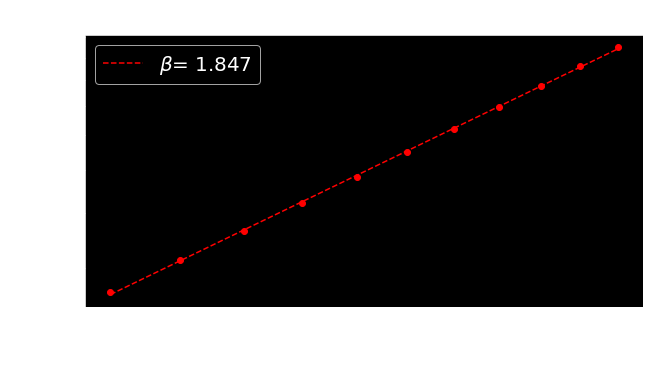

In [19]:
def test_func(x, b, c): 
    return x*b + c

x = QFI_table[:, 0]
y1 = QFI_table[:, 4]

b = 2; c = 1
popt1, pcov1 = opt.curve_fit(test_func, np.log(x), np.log(y1), p0=[b,c], maxfev=20000)
b1 = popt1[0]; c1 = popt1[1]

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(x, y1, "or")
ax.plot(x, (x**b1)*np.exp(c1), "--r", label=r"$\beta$= %.3f" %(b1))
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc="best")
ax.set_xlabel(r"$L$")
ax.set_title(r"$\mathcal{F}_{\alpha_z,\alpha_z} \sim L^{\beta}$", fontsize=20)

plt.show()